In [1]:
%matplotlib inline
%precision 16
import numpy
import math
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.integrate as integrate

In [2]:
#def Heston_Integral(f, x)
   # return
def Heston_Integral(phi, K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, j):
    
    u_1 = 1.0 / 2.0
    u_2 = - 1.0 / 2.0
    a = kappa * theta
    rspi = rho * sigma * phi * 1j
    tau = T - t
    
    b_1 = kappa + _lambda - rho * sigma
    b_2 = kappa + _lambda
    
    d_1 = numpy.sqrt((rspi - b_1)**2 - sigma**2 * (2.0 * u_1 * phi * 1j - phi**2))
    d_2 = numpy.sqrt((rho * sigma * phi * 1j - b_2)**2 - sigma**2 * (2.0 * u_2 * phi * 1j - phi**2))
    
    g_1 = (b_1 - rspi + d_1) / (b_1 - rspi - d_1)
    g_2 = (b_2 - rspi + d_2) / (b_2 - rspi - d_2)
   
    D_1 = (b_1 - rspi + d_1) / sigma**2 * ((1.0 - numpy.exp(d_1 * tau)) / (1.0 - g_1 * numpy.exp(d_1 * r)))
    D_2 = (b_2 - rspi + d_2) / sigma**2 * ((1.0 - numpy.exp(d_2 * tau)) / (1.0 - g_2 * numpy.exp(d_2 * r)))
    
    C_1 = r * phi * 1j * tau + a / sigma**2 * ((b_1 - rspi + d_1) * tau - 2.0 * numpy.log((1.0 - g_1 * numpy.exp(d_1 * tau))/(1.0 - g_1)))
    C_2 = r * phi * 1j * tau + a / sigma**2 * ((b_2 - rspi + d_2) * tau - 2.0 * numpy.log((1.0 - g_2 * numpy.exp(d_2 * tau))/(1.0 - g_2)))   
    
    f_1 = numpy.exp(C_1 + D_1 * v + 1j * phi * numpy.log(S))
    f_2 = numpy.exp(C_2 + D_2 * v + 1j * phi * numpy.log(S))
    
    if(j==1):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_1)/(1j * phi))
    elif(j==2):
        return numpy.real((numpy.exp(-1j * phi * numpy.log(K)) * f_2)/(1j * phi))

In [3]:
# The closed-form solution for Heston PDE
from scipy.integrate import quad
def Exact_Solution(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda):
    
    P_1 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 1))[0]
    P_2 = 0.5 + 1.0 / numpy.pi * quad(Heston_Integral, 0, 1000, args=(K, S, v, T, t, r, kappa, theta, sigma, rho, _lambda, 2))[0]
    
    Call = S * P_1 - K * numpy.exp(- r * (T - t)) * P_2
    return Call

/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log
/Users/yuhsuan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


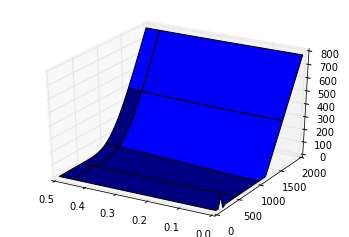

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

K = 1200.0
T = 0.125
t = 0.0
r = 0.01
kappa = 0.02
theta = 0.04
sigma = 0.01
rho = - 0.5
_lambda = 0.01


fig = plt.figure()
ax = fig.gca(projection='3d')
v = np.linspace(0.0, 0.5, 12)
s = np.arange(0, 2000, 52)
V, S = np.meshgrid(v, s)

z = np.array([Exact_Solution(K, s, v, T, t, r, kappa, theta, sigma, rho, _lambda)\
              for v, s in zip(np.ravel(V), np.ravel(S))])
Z = z.reshape(V.shape)

ax.plot_surface(V, S, Z)
ax.set_zlim(0, 800)
ax.set_xlim(0.5, 0.0)
ax.set_ylim(0, 2000)
plt.show()


In [18]:
K = 1200.0
S = 1846.0
V = 200
T = 0.125
t = 0.0
r = 0.03
kappa = 2
theta = 0.05
sigma = 0.01
rho = 0.5
_lambda = 0.0

print Exact_Solution(K, S, V, T, t, r, kappa, theta, sigma, rho, _lambda)

1831.61174881
